# ML-Powered Network Intrusion Detection System (NIDS)

This notebook walks through the complete process of building a machine learning model to detect network intrusions using the CIC-IDS2017 dataset.

### Cell 1: Project Setup and Library Imports

In [4]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


### Cell 2: Data Loading and Merging

First, we'll load all the individual CSV files from the dataset and merge them into a single pandas DataFrame. The path is relative to the project root.

In [5]:
# Path is relative to the notebook's location inside the 'notebooks' directory
data_path = os.path.join("..", "data", "MachineLearningCVE", "*.csv")
all_files = glob.glob(data_path)

# Load and concatenate all CSV files into a single DataFrame
df_list = []
for filename in all_files:
    print(f"Loading {os.path.basename(filename)}...")
    df_list.append(pd.read_csv(filename))

df = pd.concat(df_list, ignore_index=True)

print("\nAll CSV files have been loaded and merged.")
print(f"Total dataset shape: {df.shape}")

Loading Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
Loading Monday-WorkingHours.pcap_ISCX.csv...
Loading Friday-WorkingHours-Morning.pcap_ISCX.csv...
Loading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
Loading Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
Loading Tuesday-WorkingHours.pcap_ISCX.csv...
Loading Wednesday-workingHours.pcap_ISCX.csv...
Loading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...

All CSV files have been loaded and merged.
Total dataset shape: (2830743, 79)


### Cell 3: Initial Data Exploration & Cleaning

This step is crucial for understanding the data and preparing it for the model. We will:
1. Clean column names.
2. Handle infinite and missing values which can cause errors during training.

In [7]:
# Display first 5 rows
print("Dataset Head:")
display(df.head())

# Clean up column names by removing leading/trailing spaces
df.columns = df.columns.str.strip()
print("\nColumn names cleaned.")

# Check for missing values and infinite values
print("\nChecking for null and infinite values...")
# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with any NaN values
df.dropna(inplace=True)

print(f"Shape after dropping NA values: {df.shape}")

# Check data types for a concise summary
print("\nData Types Summary:")
df.info(verbose=False)

Dataset Head:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,166,1,1,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
1,60148,83,1,2,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
2,123,99947,1,1,48,48,48,48,48.0,0.0,...,40,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
3,123,37017,1,1,48,48,48,48,48.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
4,0,111161336,147,0,0,0,0,0,0.0,0.0,...,0,1753752.625,2123197.578,4822992,95,9463032.7,2657727.996,13600000,5700287,BENIGN



Column names cleaned.

Checking for null and infinite values...
Shape after dropping NA values: (2827876, 79)

Data Types Summary:
<class 'pandas.core.frame.DataFrame'>
Index: 2827876 entries, 0 to 2830742
Columns: 79 entries, Destination Port to Label
dtypes: float64(24), int64(54), object(1)
memory usage: 1.7+ GB


### Cell 4: Analyzing the Target Variable ('Label')

Here, we'll examine the distribution of the different traffic types. This will show us how imbalanced the dataset is.

Distribution of Labels (Attacks vs. Benign):
Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


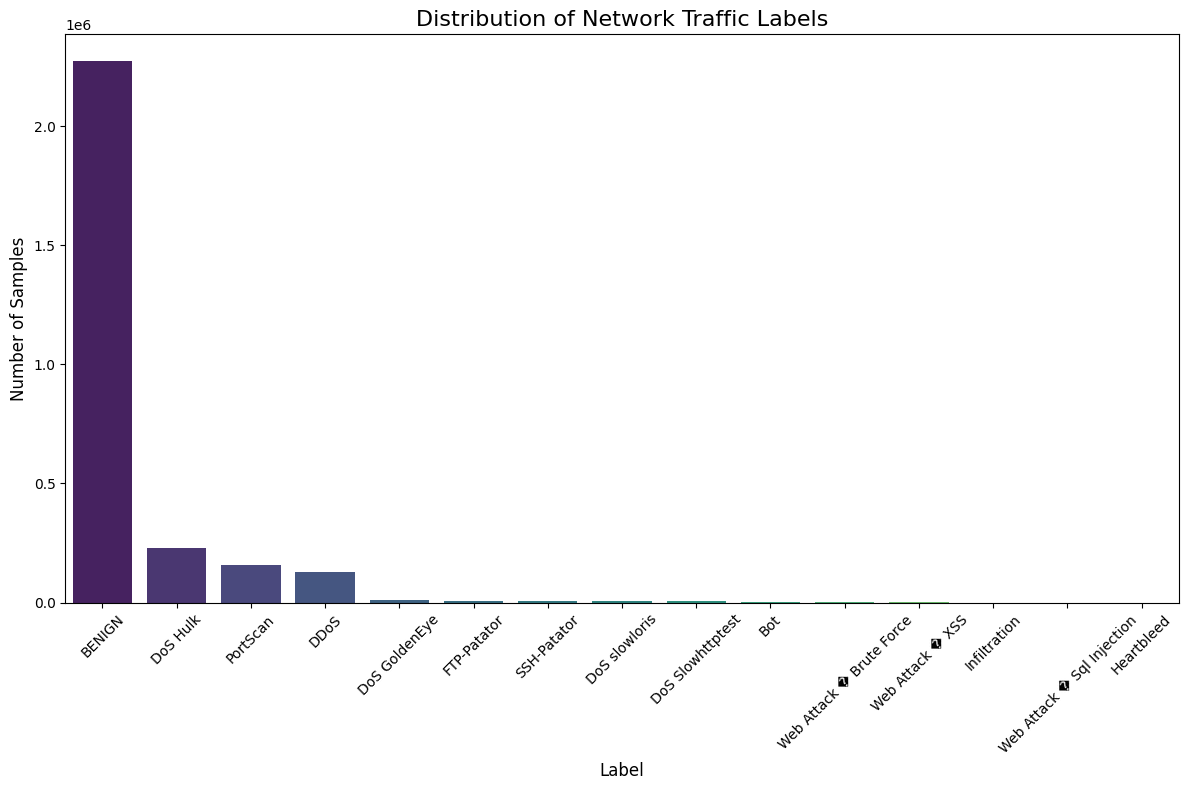

In [8]:
label_counts = df['Label'].value_counts()
print("Distribution of Labels (Attacks vs. Benign):")
print(label_counts)

# Visualize the label distribution
plt.figure(figsize=(12, 8))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title('Distribution of Network Traffic Labels', fontsize=16)
plt.ylabel('Number of Samples', fontsize=12)
plt.xlabel('Label', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Cell 5: Preprocessing for Binary Classification

For our first model, we'll simplify the problem into a binary classification task: is the traffic `BENIGN` (0) or an `Attack` (1)? We also need to separate our features (X) from our target variable (y).

In [9]:
# Create a binary label: 1 for any attack, 0 for BENIGN
df['Attack'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

# Drop the original multi-class 'Label' column
df_binary = df.drop('Label', axis=1)

print("Binary 'Attack' column created.")
print(df_binary['Attack'].value_counts())

# Separate features (X) and target (y)
X = df_binary.drop('Attack', axis=1)
y = df_binary['Attack']

# Check for non-numeric columns (often an issue)
# 'object' dtype columns cannot be used directly in most models
non_numeric_columns = X.select_dtypes(include=['object']).columns
if not non_numeric_columns.empty:
    print(f"\nWarning: Found non-numeric columns: {list(non_numeric_columns)}. These need to be encoded or dropped.")
    # For this project, we will drop them for simplicity, but encoding is a better practice.
    X = X.drop(non_numeric_columns, axis=1)
    print(f"Dropped non-numeric columns.")

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

Binary 'Attack' column created.
Attack
0    2271320
1     556556
Name: count, dtype: int64

Features shape: (2827876, 78)
Target shape: (2827876,)


### Cell 6: Data Splitting and Scaling

We'll split the data into training and testing sets. It's crucial to scale the features so that no single feature disproportionately influences the model's learning process.

In [10]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Scale numerical features
# Using StandardScaler to give all features a similar scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData has been split and scaled.")

Training set size: 2262300
Test set size: 565576

Data has been split and scaled.


### Cell 7: Training a Random Forest Model (Binary Classification)

Now we'll train our classifier. Random Forest is a powerful and generally high-performing model, making it a great choice for this task.

In [11]:
# Initialize the model. n_jobs=-1 uses all available CPU cores.
# random_state ensures reproducibility.
rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

print("Training the model... (This may take a few minutes)")
rfc.fit(X_train_scaled, y_train)
print("Model training complete.")

Training the model... (This may take a few minutes)
Model training complete.


### Cell 8: Evaluating the Model

After training, we must evaluate the model's performance on the unseen test data. We'll look at:
- **Accuracy:** Overall correctness.
- **Classification Report:** Precision, Recall, and F1-score for each class.
- **Confusion Matrix:** A table showing true vs. predicted labels.

Accuracy Score:
0.9990

Classification Report:
              precision    recall  f1-score   support

  Benign (0)       1.00      1.00      1.00    454265
  Attack (1)       1.00      1.00      1.00    111311

    accuracy                           1.00    565576
   macro avg       1.00      1.00      1.00    565576
weighted avg       1.00      1.00      1.00    565576


Confusion Matrix:


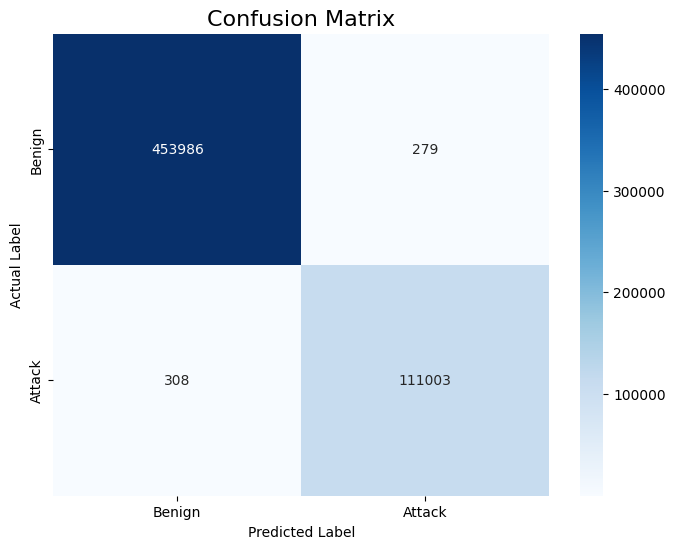

In [12]:
# Make predictions on the test set
y_pred = rfc.predict(X_test_scaled)

# Print evaluation metrics
print("Accuracy Score:")
print(f"{accuracy_score(y_test, y_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign (0)', 'Attack (1)']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Cell 9: Feature Importance Analysis

Finally, let's investigate *which* network features the model found most useful for distinguishing between benign and malicious traffic. This provides valuable insights into the nature of the attacks.

Top 20 Most Important Features:


,feature,importance
39,Max Packet Length,0.065928
54,Avg Bwd Segment Size,0.065232
42,Packet Length Variance,0.059326
41,Packet Length Std,0.053912
0,Destination Port,0.051784
52,Average Packet Size,0.051686
10,Bwd Packet Length Max,0.041571
13,Bwd Packet Length Std,0.039425
5,Total Length of Bwd Packets,0.032424
63,Subflow Fwd Bytes,0.030896


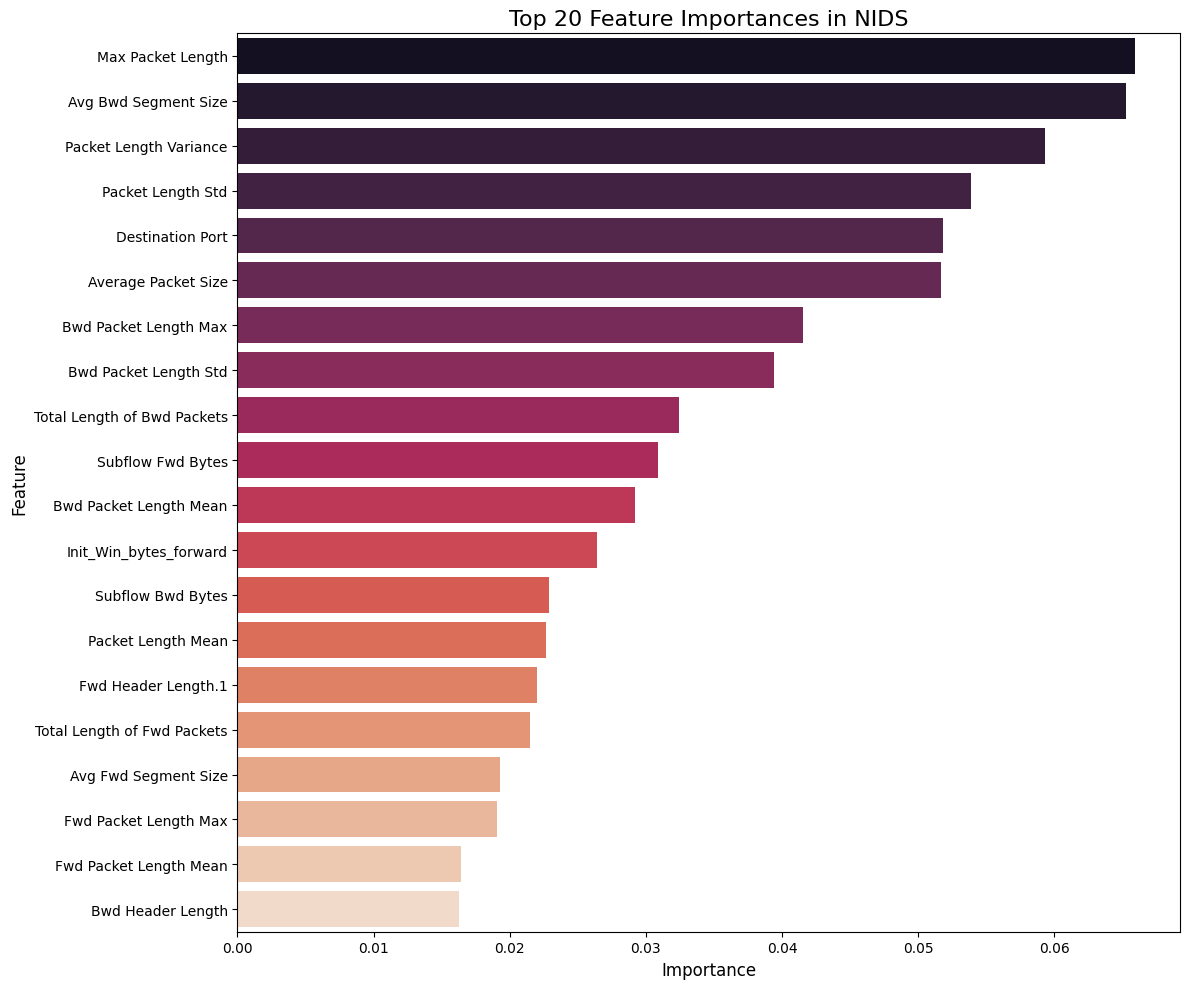

In [13]:
# Get feature importances from the trained model
importances = rfc.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
display(feature_importance_df.head(20))

# Visualize the top features
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='rocket')
plt.title('Top 20 Feature Importances in NIDS', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()